In [1]:
import pypsa
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt

from plotting_constants import nice_names, color_dict

In [48]:
# start, end = '2022-01-01', '2023-06-30'
# start, end = '2022-01-01', '2024-12-31'
start, end = '2022-01-01', '2022-12-31'

date_range = pd.date_range(start, end).strftime('%Y-%m-%d')

In [49]:
mp = pd.read_csv(Path.cwd().parent / 'summaries' / 'marginal_prices_summary_flex.csv', index_col=0, parse_dates=True, header=[0,1])
sc = pd.read_csv(Path.cwd().parent / 'summaries' / 'total_summary_flex.csv', index_col=[0,1], parse_dates=True)

C:\Users\lukas\AppData\Local\Temp\ipykernel_35364\619580916.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sc = pd.read_csv(Path.cwd().parent / 'summaries' / 'total_summary_flex.csv', index_col=[0,1], parse_dates=True)


In [50]:
sc.index.get_level_values(1).unique()

Index(['wholesale', 'congestion_rent', 'cfd_payments', 'roc_payments',
       'offer_cost', 'bid_cost', 'balancing_volume'],
      dtype='object')

In [51]:
lw = pd.read_csv(Path.cwd().parent / 'data' / 'preprocessed' / 'load_weights.csv', index_col=0)
lw.index = lw.index.astype(str)

In [52]:
regions = gpd.read_file(Path.cwd().parent / 'data' / 'regions_onshore_s.geojson')

In [53]:
bmus = pd.read_csv(Path.cwd().parent / 'data' / 'preprocessed' / 'prepared_bmus.csv', index_col=0)
foss = bmus.loc[bmus.loc[:, 'carrier'] == 'fossil']

foss

,carrier,bus,lon,lat
NationalGridBmUnit,,,,
BRGDG-1,fossil,6038,-0.508006,53.540993
AG-NHAV02,fossil,5913,-3.781,55.803
ABERU-1,fossil,6049,-1.270137,53.090486
BRGG-1,fossil,6042,-0.32959,53.442264
BRIDU-1,fossil,6037,-0.203475,54.086555
...,...,...,...,...
GRAI-6,fossil,4972,0.703125,51.47454
GRAI-7,fossil,4972,0.703125,51.47454
GRAI-8,fossil,4972,0.703125,51.47454


In [54]:
'''
loads = []

for day in date_range:

    try:
        n = pypsa.Network(Path.cwd().parent / 'results' / day / 'network_flex_s_national.nc')
        l = n.loads.query('carrier == "electricity"').index
        loads.append(n.loads_t.p_set[l])
    except FileNotFoundError:
        continue

loads = pd.concat(loads)
'''

# loads = pd.read_csv('hold_loads.csv', index_col=0, parse_dates=True)
loads = pd.read_csv(
    Path.cwd().parent / 'summaries' / 'total_gb_load.csv', index_col=0, parse_dates=True
    ).loc[start:end]

In [55]:
# loads.to_csv('hold_loads.csv')

In [56]:
from tqdm import tqdm

pns = []

for day in tqdm(date_range):

    try:
        pns.append(
            pd.read_csv(
                Path.cwd().parent / 'data' / 'base' / day / 'physical_notifications.csv',
                index_col=0
                )
            )
    except FileNotFoundError:
        continue

pns = pd.concat(pns)

  0%|          | 0/365 [00:00<?, ?it/s]

100%|██████████| 365/365 [00:10<00:00, 35.67it/s]


In [57]:
from tqdm import tqdm

dap = []

for day in tqdm(date_range):

    try:
        dap.append(
            pd.read_csv(
                Path.cwd().parent / 'data' / 'base' / day / 'day_ahead_prices.csv',
                index_col=0
                )
            )
    except FileNotFoundError:
        continue

dap = pd.concat(dap).iloc[:,0]

100%|██████████| 365/365 [00:00<00:00, 883.82it/s]


In [58]:
gas_gen = pns.loc[:, pns.columns.intersection(foss.index)].sum(axis=1)

In [59]:
(dap <= 0).sum() / len(dap)

0.007591324200913242

In [81]:
idx = pd.IndexSlice

zmp = mp.loc[start:end, idx['zonal',:]]
nmp = mp.loc[start:end, idx['national',:]]

In [82]:
n_values = zmp.apply(lambda x: x.nunique(), axis=1)

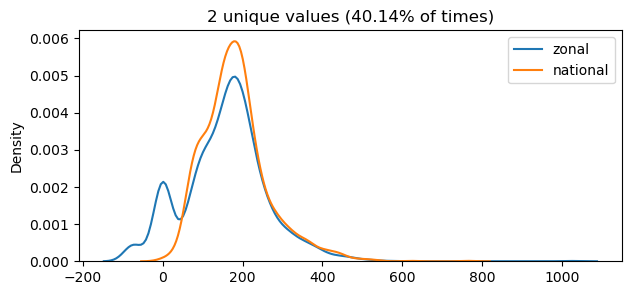

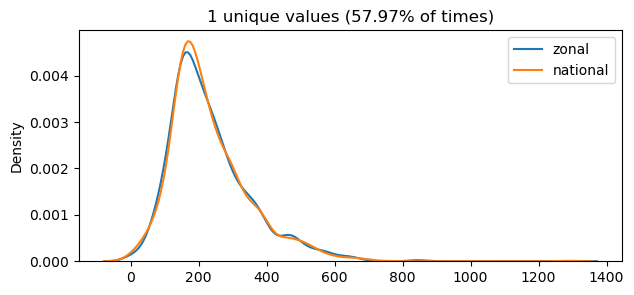

In [83]:
import seaborn as sns

for i in n_values.unique()[:2]:

    ssz = zmp.loc[n_values.loc[n_values == i].index]
    ssn = nmp.loc[n_values.loc[n_values == i].index]

    fig, ax = plt.subplots(figsize=(7, 3))

    sns.kdeplot(np.random.choice(ssz.values.flatten(), 2000), ax=ax, label='zonal')
    sns.kdeplot(np.random.choice(ssn.values.flatten(), 2000), ax=ax, label='national')

    share_of_times = np.around(100 * (ssn.shape[0] / len(nmp.index)), 2)

    ax.set_title(f'{i} unique values ({share_of_times}% of times)')

    ax.legend()
    plt.show()



In [84]:
(zmp < 0).any(axis=1).sum() / len(zmp)

0.05537595785440613

In [85]:
nmp.columns = nmp.columns.get_level_values(1)

In [86]:
zmp.columns = zmp.columns.get_level_values(1)

In [87]:
def classify_period(nat, lmp):

    nat = nat.copy()
    lmp = lmp.copy()

    nat_negative_mask = nat.loc[nat.iloc[:,0] <= 0].index

    nat_negative_prices = {
        'national': nat.loc[nat_negative_mask],
        'zonal': lmp.loc[nat_negative_mask],
    }

    lmp.drop(nat_negative_mask, inplace=True)
    nat.drop(nat_negative_mask, inplace=True)

    all_positive_mask = lmp.loc[(lmp > 0).all(axis=1)].index

    all_positive_prices = {
        'national': nat.loc[all_positive_mask],
        'zonal': lmp.loc[all_positive_mask],
    }

    lmp.drop(all_positive_mask, inplace=True)
    nat.drop(all_positive_mask, inplace=True)

    mixed_prices = {
        'national': nat,
        'zonal': lmp,
    }

    return nat_negative_prices, all_positive_prices, mixed_prices


neg, pos, mixed = classify_period(nmp, zmp)

In [88]:

def bars_to_ax(ax, lmp, loads, weights, costs, index_groups):

    distributed_price = costs.sum().drop('wholesale') / loads.sum().sum() * 1e6 #/2

    total_load = loads.sum().sum()

    bar_kwargs = {
        'alpha': 0.8,
    }
    # Create distinct colors for each cost component.

    for j, group in enumerate(index_groups):

        cumulative_positive = 0
        cumulative_negative = 0

        for i, (cat, value) in enumerate(distributed_price.items()):

            if value >= 0:
                ax.bar(j-0.25, value, width=0.5, bottom=cumulative_positive,
                    color=color_dict[cat], align='edge', label=f"cost: {cat}", **bar_kwargs)
                ax.plot(
                    [j-0.25, j+0.25],
                    [cumulative_positive + value, cumulative_positive + value],
                    color='k',
                    alpha=0.5,
                    lw=0.5,
                )
                cumulative_positive += value
            else:
                ax.bar(j-0.25, value, width=0.5, bottom=cumulative_negative,
                    color=color_dict[cat], align='edge', label=f"cost: {cat}", **bar_kwargs)
                ax.plot(
                    [j-0.25, j+0.25],
                    [cumulative_negative + value, cumulative_negative + value],
                    color='k',
                    alpha=0.5,
                    lw=0.5,
                )
                cumulative_negative += value

        assert len(lmp[group].iloc[0].unique()) == 1, "There should be only one unique value in the group"
        lmp_group = lmp[group].mean(axis=1)

        avg = (lmp_group * loads.values.flatten()).sum() / total_load
        x_loc = j - 0.25
        bar_width = 0.5

        if avg >= 0:
            ax.bar(
                x_loc,
                avg,
                width=bar_width,
                bottom=cumulative_positive,
                align='edge',
                label="lmp_group",
                color=color_dict['wholesale'],
                **bar_kwargs,
            )
            ax.plot(
                [x_loc, x_loc + bar_width],
                [cumulative_positive + avg, cumulative_positive + avg],
                color='k',
                alpha=0.5,
                lw=0.5,
            )
        else:
            ax.bar(
                x_loc,
                avg,
                width=bar_width,
                bottom=cumulative_negative,
                align='edge',
                label="lmp_group",
                color=color_dict['wholesale'],
                **bar_kwargs,
            )
            ax.plot(
                [x_loc, x_loc + bar_width],
                [cumulative_negative + avg, cumulative_negative + avg],
                color='k',
                alpha=0.5,
                lw=0.5,
            )
        ax.plot(
            [x_loc, x_loc + bar_width],
            [cumulative_positive + cumulative_negative + avg, cumulative_positive + cumulative_negative + avg],
            color='r',
            alpha=0.5,
        )

In [89]:
ss = mixed['zonal'].iloc[0]

low_cost_regions = ss[ss < 0].index
high_cost_regions = ss[ss > 0].index

In [90]:
from shapely.ops import unary_union
import geopandas as gpd

def regions_to_ax(regions, ax, dark_regions):

    if not dark_regions.empty:
        gpd.GeoSeries([unary_union(regions.loc[dark_regions].geometry)]).plot(ax=ax, color='midnightblue', alpha=0.8, edgecolor='none', lw=0.5)
    gpd.GeoSeries([unary_union(regions.geometry)]).plot(ax=ax, facecolor='none', edgecolor='k', alpha=1, lw=0.3)
    ax.set_xticks([])
    ax.set_yticks([])

In [92]:
from copy import deepcopy


def get_wholesale_costs(mps, loads, lw):

    loads = loads.copy() / 2
    lw = lw.copy().loc[mps.columns].values

    # print(mps.mean(axis=1))
    weighted_row_means = (mps.mul(lw, axis=1)).sum(axis=1)# / lw.sum()
    # print(weighted_row_means)

    if len(loads.shape) > 1:
        loads = loads.sum(axis=1).values
    else:
        loads = loads.values

    return (weighted_row_means * loads).sum() / loads.sum()# / lw.loc[mps.columns].sum()


print('Warning! Double check wholesale prices')

def get_total_prices(sc, mps, loads, lw, layout, aggregate_time=True):

    mps = deepcopy(mps)

    try:
        mps = mps[layout]
    except KeyError:
        pass

    costs = sc.loc[idx[mps.index, :], layout].unstack().drop(columns=['balancing_volume'])

    if aggregate_time:
        return costs.sum() / loads.loc[costs.index].sum().sum() * 1e6
    else:
        return costs.div(loads.loc[costs.index].values.flatten(), axis=0) * 1e6


get_total_prices(sc, neg['national'], loads, pd.Series(1, ['GB']), 'national', aggregate_time=False).head()

Warning! Double check wholesale prices


,bid_cost,cfd_payments,congestion_rent,offer_cost,roc_payments,wholesale
2022-01-03 05:00:00,2.069262,14.495140,0.0,7.883885,25.578474,0.0
2022-02-17 03:00:00,0.080932,12.308784,0.0,0.465308,24.379296,0.0
2022-02-17 03:30:00,0.233814,12.513631,0.0,1.344278,24.433481,0.0
2022-02-17 04:00:00,0.044293,12.180103,0.0,0.254655,25.034017,0.0
2022-02-17 04:30:00,0.311386,12.828387,0.0,1.790269,25.035761,0.0


In [93]:
def simple_bars_to_ax(ax, values):

    cumulative_positive = 0
    cumulative_negative = 0

    bar_kwargs = {
        'alpha': 0.8,
    }

    for i, (cat, value) in enumerate(values.items()):

        if value >= 0:
            ax.bar(-0.25, value, width=0.5, bottom=cumulative_positive,
                color=color_dict[cat], align='edge', label=f"cost: {cat}", **bar_kwargs)
            ax.plot(
                [-0.25, 0.25],
                [cumulative_positive + value, cumulative_positive + value],
                color='k',
                alpha=0.5,
                lw=0.5,
            )
            cumulative_positive += value
        else:
            ax.bar(-0.25, value, width=0.5, bottom=cumulative_negative,
                color=color_dict[cat], align='edge', label=f"cost: {cat}", **bar_kwargs)
            ax.plot(
                [-0.25, 0.25],
                [cumulative_negative + value, cumulative_negative + value],
                color='k',
                alpha=0.5,
                lw=0.5,
            )
            cumulative_negative += value
        
    total = cumulative_positive + cumulative_negative
    ax.plot(
        [-0.25, 0.25],
        [total, total],
        color='red',
        lw=2,
    )

    ax.plot(
        [-0.25, 0.25],
        [values.drop('congestion_rent').sum(), values.drop('congestion_rent').sum()],
        color='red',
        linestyle='-.',
        alpha=0.8,
        lw=2,
    )


In [94]:
fp = pd.read_excel(
    Path.cwd() / 'systemaveragepriceofgasdataset130225.xlsx',
    sheet_name=3,
    parse_dates=True,
    index_col=0,
    skiprows=1
    )

def process(df):

    df = (
        df.iloc[4:]
        .rename(
        columns={
            'Unnamed: 1': 'day_price',
            'Unnamed: 2': 'before_week_average',
        })
        .replace('[x]', np.nan)
        ['day_price']
        )
    df.index.name = 'date'
    df.index = pd.to_datetime(df.index)
    return df * 10

fp = process(fp)

C:\Users\lukas\AppData\Local\Temp\ipykernel_35364\2051069817.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fp = pd.read_excel(
C:\Users\lukas\AppData\Local\Temp\ipykernel_35364\2051069817.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace('[x]', np.nan)


<Axes: xlabel='date'>

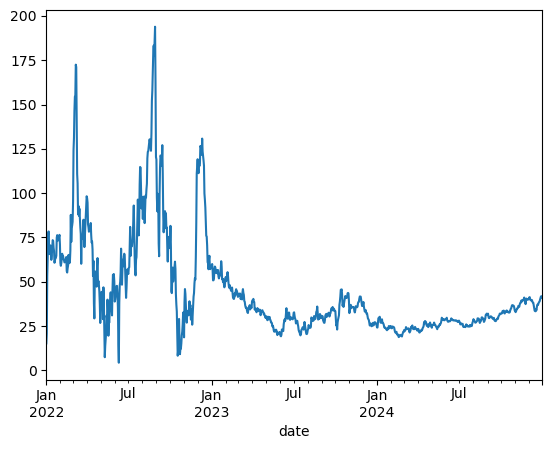

In [95]:
fp.loc['2022':'2024-12-31'].plot()

In [96]:
fp.loc['2022':'2025-01-01'].tail()

date
2024-12-28    41.741
2024-12-29    41.607
2024-12-30    41.013
2024-12-31    41.601
2025-01-01    41.922
Name: day_price, dtype: float64

In [99]:
n = neg['zonal'].index

fp.loc[n.strftime('%Y-%m-%d')].head()

snapshot
2022-01-03    53.38
2022-02-17    57.55
2022-02-17    57.55
2022-02-17    57.55
2022-02-17    57.55
Name: day_price, dtype: float64

In [100]:
def get_weighted_average_price(df, weights):

    weighted_sum = df.multiply(weights.loc[df.index].values, axis=0) \
                            .groupby(df.index.strftime('%Y-%m-%d')).sum()
        
    daily_weights = weights.loc[df.index] \
                        .groupby(df.index.strftime('%Y-%m-%d')).sum()

    return weighted_sum.divide(daily_weights.values, axis=0)


2022-01-03 05:00:00   -20.498906
2022-12-30 07:00:00    -4.123289
2022-12-30 07:30:00    -2.851479
2022-12-30 05:00:00    -2.122853
2022-02-17 04:00:00    -1.934759
2022-12-30 06:00:00    -1.520288
2022-12-30 05:30:00    -1.228626
2022-12-30 06:30:00    -1.160760
2022-12-29 05:00:00    -0.736459
2022-12-29 02:30:00    -0.604554
2022-12-28 23:00:00    -0.268125
2022-12-30 04:30:00    -0.264513
2022-12-27 23:00:00    -0.187802
2022-12-29 03:00:00    -0.177329
2022-12-25 06:30:00    -0.171916
2022-12-26 04:00:00    -0.139458
2022-12-29 04:30:00    -0.107508
2022-12-29 03:30:00    -0.087685
2022-12-18 23:00:00    -0.078270
2022-12-29 05:30:00    -0.077838
2022-12-18 23:30:00    -0.055799
2022-12-28 23:30:00     0.000000
2022-12-29 04:00:00     0.052114
2022-12-27 23:30:00     0.056988
2022-12-28 22:00:00     0.060122
2022-12-26 04:30:00     0.067378
2022-12-28 22:30:00     0.261771
2022-12-30 03:30:00     0.367555
2022-12-30 02:30:00     0.396541
2022-12-29 02:00:00     0.450751
2022-12-30

SystemExit: 

c:\Users\lukas\miniforge3\envs\pypsa-eur\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


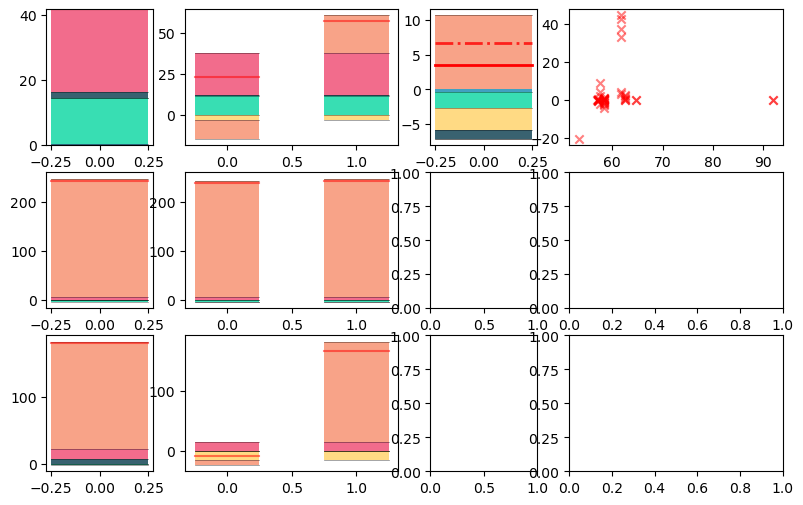

In [106]:
import seaborn as sns

fig, axs = plt.subplots(3, 4, figsize=(9.5, 6), gridspec_kw={'width_ratios': [1, 2, 1, 2]})

bars_to_ax(
    axs[0,1],
    neg['zonal'],
    loads.loc[neg['zonal'].index],
    lw,
    sc.loc[idx[neg['zonal'].index, :], 'zonal'].unstack().drop(columns=['balancing_volume']),
    [low_cost_regions, high_cost_regions]
    )

bars_to_ax(
    axs[0,0],
    neg['national'],
    loads.loc[neg['national'].index],
    lw,
    sc.loc[idx[neg['national'].index, :], 'national'].unstack().drop(columns=['balancing_volume']),
    [['GB']]
    )

bars_to_ax(
    axs[1,1],
    pos['zonal'],
    loads.loc[pos['zonal'].index],
    lw,
    sc.loc[idx[pos['zonal'].index, :], 'zonal'].unstack().drop(columns=['balancing_volume']),
    [low_cost_regions, high_cost_regions]
    )

bars_to_ax(
    axs[1,0],
    pos['national'],
    loads.loc[pos['national'].index],
    lw,
    sc.loc[idx[pos['national'].index, :], 'national'].unstack().drop(columns=['balancing_volume']),
    [['GB']]
    )

bars_to_ax(
    axs[2,1],
    mixed['zonal'],
    loads.loc[mixed['zonal'].index],
    lw,
    sc.loc[idx[mixed['zonal'].index, :], 'zonal'].unstack().drop(columns=['balancing_volume']),
    [low_cost_regions, high_cost_regions]
    )

bars_to_ax(
    axs[2,0],
    mixed['national'],
    loads.loc[mixed['national'].index],
    lw,
    sc.loc[idx[mixed['national'].index, :], 'national'].unstack().drop(columns=['balancing_volume']),
    [['GB']]
    )

neg_zonal = get_total_prices(sc, neg['zonal'], loads, lw.iloc[:,0], 'zonal')
neg_national = get_total_prices(sc, neg['national'], loads, pd.Series(1, ['GB']), 'national')

neg_diff = neg_zonal - neg_national
simple_bars_to_ax(
    axs[0,2],
    neg_diff,
)

####### Temporally disaggregated
for ax, data in zip(axs[:,3], [neg, pos, mixed]):

    zonal_disagg = get_total_prices(
        sc,
        data['zonal'],
        loads,
        lw.iloc[:,0],
        'zonal',
        aggregate_time=False
        )

    national_disagg = get_total_prices(
        sc,
        data['national'],
        loads,
        pd.Series(1, ['GB']),
        'national',
        aggregate_time=False
        )

    diff_disagg = zonal_disagg - national_disagg

    x = fp.loc[diff_disagg.index.strftime('%Y-%m-%d')]

    # x = x.groupby(x.index).mean()

    # print(diff_disagg.head())
    # y = get_weighted_average_price(diff_disagg, loads)
    # import sys; sys.exit()

    # total = y.sum(axis=1)
    # interesting_cols = ['offer_cost', 'congestion_rent', 'wholesale']

    # for col in interesting_cols:
    #     ax.scatter(x, y.loc[:, col].values, alpha=0.75, c=color_dict[col], marker='x', s=10)

    # sns.regplot(x=x, y=y.loc[:, col].values, ax=ax, scatter=False, ci=True, line_kws={'color': color_dict[col]})
    # sns.regplot(x=x, y=y.loc[:, col].values, ax=ax, scatter=False, ci=False, line_kws={'color': 'k', 'lw': 0.5})


    ax.scatter(x, diff_disagg.sum(axis=1).values, alpha=0.5, c='r', marker='x')
    print(diff_disagg.sum(axis=1).sort_values())

    import sys; sys.exit()

for ax in axs[:,3]:
    ax.set_xlabel('')

pos_zonal = get_total_prices(sc, pos['zonal'], loads, lw.iloc[:,0], 'zonal')
pos_national = get_total_prices(sc, pos['national'], loads, pd.Series(1, ['GB']), 'national')

pos_diff = pos_zonal - pos_national
simple_bars_to_ax(
    axs[1,2],
    pos_diff,
)

mixed_zonal = get_total_prices(sc, mixed['zonal'], loads, lw.iloc[:,0], 'zonal')
mixed_national = get_total_prices(sc, mixed['national'], loads, pd.Series(1, ['GB']), 'national')

mixed_diff = mixed_zonal - mixed_national
simple_bars_to_ax(
    axs[2,2],
    mixed_diff,
)

for ax in axs[:, 0]:
    ax.set_xlim(-0.5, 0.5)

for ax in axs[:, 1]:
    ax.set_xlim(-0.5, 1.5)


for ax in axs[:,1]:
    ax.set_yticklabels([])
    ax.spines['left'].set_visible(False)

for ax in axs[:,2]:
    ax.spines['left'].set_visible(False)

for ax in axs.flatten():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, linestyle='--', axis='y')
    ax.set_axisbelow(True)

for ax in axs[0,:2]:
    ax.set_ylim(-70, 70)
for ax in axs[1,:2]:
    ax.set_ylim(-20, 250)
for ax in axs[2,:2]:
    ax.set_ylim(-70, 220)

ax_inset = axs[0,0].inset_axes([0.65, -0.1, 0.35, 0.5])
regions_to_ax(
    regions.set_index('name'),
    ax_inset,
    pd.Index([])
)
ax_inset = axs[0,1].inset_axes([0.8, 0.015, 0.2, 0.3])
regions_to_ax(
    regions.set_index('name'),
    ax_inset,
    high_cost_regions,
)
ax_inset = axs[1,0].inset_axes([0.65, -0.1, 0.35, 0.5])
regions_to_ax(
    regions.set_index('name'),
    ax_inset,
    high_cost_regions.union(low_cost_regions),
)
ax_inset = axs[1,1].inset_axes([0.8, 0.015, 0.2, 0.3])
regions_to_ax(
    regions.set_index('name'),
    ax_inset,
    high_cost_regions.union(low_cost_regions),
)
ax_inset = axs[2,0].inset_axes([0.65, -0.1, 0.35, 0.5])
regions_to_ax(
    regions.set_index('name'),
    ax_inset,
    high_cost_regions.union(low_cost_regions),
)
ax_inset = axs[2,1].inset_axes([0.8, 0.015, 0.2, 0.3])
regions_to_ax(
    regions.set_index('name'),
    ax_inset,
    high_cost_regions,
)

for ax in axs[:2,2]:
    ax.set_xticks([])

for ax in axs[:,2]:
    ax.set_xlim(-0.5, 0.5)

neg_share = 100 * len(neg['national']) / len(zmp)
pos_share = 100 * len(pos['national']) / len(zmp)
mixed_share = 100 * len(mixed['national']) / len(zmp)

axs[0,0].set_ylabel(f'\nHigh Wind Case\n({neg_share:.1f}% of time)')
axs[1,0].set_ylabel(f'Consumer Price (£/MWh)\nLow Wind Case\n({pos_share:.1f}% of time)')
axs[2,0].set_ylabel(f'\nMedium Wind Case\n({mixed_share:.1f}% of time)')

# labels, handles = 

for ax in axs[:,2]:
    position = ax.get_position()
    new_pos = [position.x0 + 0.025, position.y0, position.width, position.height]
    ax.set_position(new_pos)

for ax in axs[:,3]:
    position = ax.get_position()
    new_pos = [position.x0 + 0.04, position.y0, position.width, position.height]
    ax.set_position(new_pos)

title_pad = 10
axs[0,0].set_title('National Market', fontsize=10, pad=title_pad)
axs[0,1].set_title('Zonal Market', fontsize=10, pad=title_pad)
axs[0,2].set_title('Zonal-National Price\nDifference (£/MWh)', fontsize=10, pad=title_pad)
axs[0,3].set_title('Daily Price\nDifference (£/MWh)', fontsize=10, pad=title_pad, loc='left')

axs[2,1].set_xticks([0, 1])
axs[2,1].set_xticklabels(['Low Price\nRegions', 'High Price\nRegions'])
axs[2,1].tick_params(axis='x', which='both', length=0)

for ax in axs[:2,:2].flatten():
    ax.set_xticks([])

for ax in axs[:,3]:
    ax.tick_params(axis='x', which='both', length=0)

for ax in axs[:,3]:
    ax.set_xlim(0, 205)

axs[2,0].set_xticks([])
axs[2,2].set_xticks([])

axs[1,2].set_ylim(-4, 4)

for ax in axs[:,:].flatten():
    ax.axhline(0, color='k', lw=1)
    ax.spines['bottom'].set_visible(False)

for ax in axs[:,3]:
    ax.grid(True, linestyle='--')

for ax in axs[:2,3]:
    ax.set_xticklabels([''])

axs[2,3].set_xlabel('Daily GB Gas Price (£/MWh)')

handles, labels = [], []

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

for label, color in color_dict.items():

    if label in ['wholesale selling', 'wholesale buying']:
        continue

    handles.append(Patch(color=color, label=nice_names[label]))
    labels.append(nice_names[label])

handles.append(Line2D([0], [0], color='r', lw=1, linestyle='-', alpha=0.8))
labels.append("Total")

handles.append(Line2D([0], [0], color='r', lw=1, linestyle='-.', alpha=0.8))
labels.append("Total w/o Congestion Rent")

axs[2,0].legend(
    handles=handles,
    labels=labels,
    loc='upper left',
    bbox_to_anchor=(-0.6, -0.4),
    fontsize=8,
    ncol=4,
    frameon=False,
)

axs[0,0].text(
    -1.35,
    120,
    f'{start} - {end}',
    fontsize=9,
    ha='left',
    weight='bold',
)

plt.savefig(f'wind_cases_from_{start}_to_{end}.pdf', bbox_inches='tight')
plt.show()

In [126]:
import pypsa

date = '2022-02-20'

nat = pypsa.Network(
    Path.cwd().parent / 'results' / f'{day}' / 'network_flex_s_national_solved.nc'
)
zon = pypsa.Network(
    Path.cwd().parent / 'results' / f'{day}' / 'network_flex_s_zonal_solved.nc'
)


INFO:pypsa.io:Imported network network_flex_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_flex_s_zonal_solved.nc has buses, carriers, generators, links, loads, storage_units


88.9980298786
Bus
8838    88.99803
8013    88.99803
8649    88.99803
4950    88.99803
4951    88.99803
          ...   
8019    88.99803
7458    88.99803
8283    88.99803
8093    88.99803
7908    88.99803
Name: 2022-12-31 05:00:00, Length: 284, dtype: float64


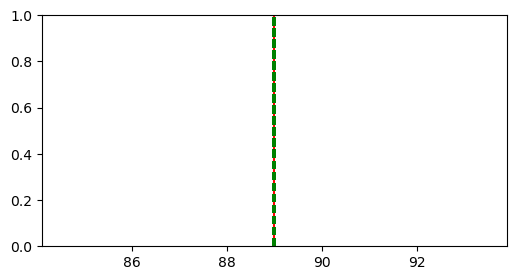

In [129]:

def show_marginal_price(nat, zon, period, ax):

    fig, ax = plt.subplots(1, 1, figsize=(6, 3))

    print(nat.buses_t.marginal_price.iloc[period].loc['GB'])
    ax.axvline(nat.buses_t.marginal_price.iloc[period].loc['GB'], color='r')

    gb_buses = zon.buses.loc[zon.buses.carrier == 'AC'].index

    print(zon.buses_t.marginal_price.iloc[period].loc[gb_buses])
    for bus in gb_buses:
        ax.axvline(zon.buses_t.marginal_price.iloc[period].loc[bus], color='g', linestyle='--')

    plt.show()


period = 10
show_marginal_price(nat, zon, period, ax)


In [81]:
x = fp.loc[diff_disagg.index.strftime('%Y-%m-%d')]

def get_weighted_average_price(df, weights):

    weighted_sum = df.multiply(weights.loc[df.index].values, axis=0) \
                            .groupby(df.index.strftime('%Y-%m-%d')).sum()
        
    daily_weights = weights.loc[df.index] \
                        .groupby(df.index.strftime('%Y-%m-%d')).sum()

    return weighted_sum.divide(daily_weights.values, axis=0)

get_weighted_average_price(diff_disagg, loads)

,bid_cost,cfd_payments,congestion_rent,offer_cost,roc_payments,wholesale
2022-01-01,-3.062712,-2.435410,-11.029440,-17.104910,0.199287,8.772162
2022-01-02,-2.767003,-2.875715,-10.586678,-8.565534,0.078944,12.838761
2022-01-03,-2.872259,-1.996431,-11.972651,-9.413910,0.105898,19.456469
2022-01-04,0.000000,1.045201,-11.372678,0.000000,0.117062,-2.183966
2022-01-05,-2.684488,0.806772,-11.213992,-7.194851,0.045098,1.552584
...,...,...,...,...,...,...
2023-03-13,-0.910892,0.525813,-6.353534,-3.209269,0.063812,-0.592118
2023-03-21,-0.410091,0.506912,-5.592014,-1.885832,0.085905,-0.677385
2023-03-22,-2.875060,-2.117593,-7.972619,-10.860203,0.592612,3.723620
2023-03-23,-0.527380,0.002971,-5.146134,-0.788060,0.038779,0.718380


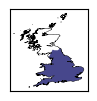

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(1, 22))

regions_to_ax(
    regions.set_index('name'),
    ax,
    high_cost_regions,
)

plt.show()